**TODO: Upload U-Net model and .tif image**

In [1]:
from torch import nn

In [2]:
class conv_relu(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding='same')
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding='same')
        self.batchnorm1 = nn.BatchNorm2d(out_channels)
        self.batchnorm2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.batchnorm1(self.conv1(x)))
        x = self.relu(self.batchnorm2(self.conv2(x)))
        # print(f"conv_relu {x.shape}")
        return x


class upsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.upconv = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels, out_channels, kernel_size=2, padding='same')
        )

    def forward(self, x):
        x = self.upconv(x)
        # print(f"up {x.shape}")
        return x

def copy_crop(contract, expand):
    start_h = (contract.shape[2] - expand.shape[2]) // 2
    start_w = (contract.shape[3] - expand.shape[3]) // 2
    end_h = start_h + expand.shape[2]
    end_w = start_w + expand.shape[3]
    cropped_contract = contract[:, :, start_h:end_h, start_w:end_w]

    concatenated = torch.cat((cropped_contract, expand), dim=1)
    # print(f"Shape after concatenation: {concatenated.shape}")
    return concatenated


In [5]:
class U_Net(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.downsample = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv1 = conv_relu(3, 64)
        self.conv2 = conv_relu(64, 128)
        self.conv3 = conv_relu(128, 256)
        self.conv4 = conv_relu(256, 512)
        self.conv5 = conv_relu(512, 1024)

        self.upsample1 = upsample(1024, 512)
        self.conv6 = conv_relu(1024, 512)

        self.upsample2 = upsample(512, 256)
        self.conv7 = conv_relu(512, 256)

        self.upsample3 = upsample(256, 128)
        self.conv8 = conv_relu(256, 128)

        self.upsample4 = upsample(128, 64)
        self.conv9 = conv_relu(128, 64)

        self.conv1x1 = nn.Conv2d(64, num_classes, kernel_size=1, stride=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x1 = self.conv1(x)
        x = self.downsample(x1)
        x2 = self.conv2(x)
        x = self.downsample(x2)
        x3 = self.conv3(x)
        x = self.downsample(x3)
        x4 = self.conv4(x)
        x = self.downsample(x4)
        x = self.conv5(x)

        x = self.upsample1(x)
        x = copy_crop(x4, x)
        x = self.conv6(x)

        x = self.upsample2(x)
        x = copy_crop(x3, x)
        x = self.conv7(x)

        x = self.upsample3(x)
        x = copy_crop(x2, x)
        x = self.conv8(x)

        x = self.upsample4(x)
        x = copy_crop(x1, x)
        x = self.conv9(x)
        x = self.conv1x1(x)
        x = self.sigmoid(x)

        return x

In [15]:
import torch
from torchvision.transforms import v2
import cv2
import numpy as np
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

# Load model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = U_Net(num_classes=1).to(device)
model.load_state_dict(torch.load("unet_model.pth", map_location=device))
model.eval()

<ipython-input-15-9e3c9a66de6c>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("unet_model.pth", map_location=device))


U_Net(
  (downsample): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): conv_relu(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2): conv_relu(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (batchnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (batchnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv3): conv_relu(
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (co

In [18]:
from PIL import Image

def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")  # Ensure 3-channel input
    transform = v2.Compose([
      v2.ToTensor(),
      v2.ToDtype(torch.float32, scale=True),
    ])
    image_tensor = transform(image).unsqueeze(0).to(device)
    print(image_tensor.shape)
    return image_tensor

image_tensor = preprocess_image("/content/img.tif")


torch.Size([1, 3, 256, 256])


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [19]:
with torch.no_grad():
    pred = model(image_tensor)

pred = pred.squeeze(0).squeeze(0).cpu().numpy()
binary_pred = pred > 0.5  # Thresholding


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


torch.Size([1, 3, 256, 256])


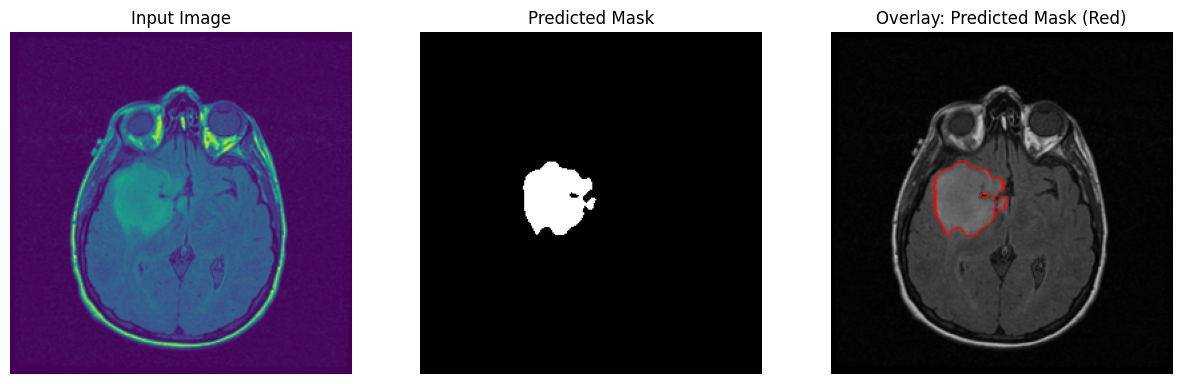

In [26]:
import tifffile as tiff

def visualize_inference_and_save(image_path, output_mask_path, model):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image_tensor = preprocess_image(image_path)

    with torch.no_grad():
        pred = model(image_tensor)

    pred = pred.squeeze(0).squeeze(0).cpu().numpy()
    binary_pred = pred > 0.5  # Threshold

    binary_pred_resized = cv2.resize(binary_pred.astype(np.uint8),
                                     (image.shape[1], image.shape[0]),
                                     interpolation=cv2.INTER_NEAREST)

    # Overlay segmentation boundaries
    mask_overlay = mark_boundaries(image, binary_pred.astype(int), color=(1, 0, 0))

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    tiff.imwrite(output_mask_path, binary_pred_resized.astype(np.uint8))

    axes[0].imshow(image)
    axes[0].set_title("Input Image")
    axes[0].axis("off")

    axes[1].imshow(binary_pred_resized, cmap="gray")
    axes[1].set_title("Predicted Mask")
    axes[1].axis("off")

    axes[2].imshow(mask_overlay)
    axes[2].set_title("Overlay: Predicted Mask (Red)")
    axes[2].axis("off")

    plt.show()

# Run visualization
predicted_mask_path = "/content/predicted_mask.tif"
visualize_inference_and_save("/content/img.tif", predicted_mask_path, model)


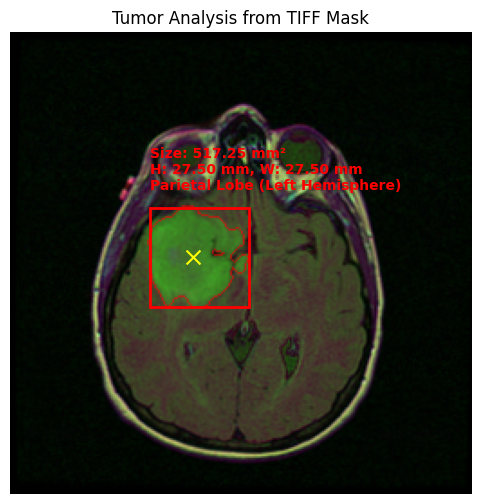

Tumor 1: 2069 pixels, 517.25 mm², Height: 27.50 mm, Width: 27.50 mm, Location: Parietal Lobe (Left Hemisphere)


In [66]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tifffile as tiff
from skimage.segmentation import mark_boundaries

# Default pixel spacing assumption (0.5 mm per pixel)
PIXEL_SPACING = 0.5  # mm per pixel

def determine_lobe(centroid, img_shape):
    """
    Determines the approximate tumor location based on the centroid position.
    Assumes a standard axial view MRI.
    """
    h, w = img_shape[:2]
    x, y = centroid

    # Define hemispheres
    hemisphere = "Left Hemisphere" if x < w / 2 else "Right Hemisphere"

    # Define anterior-posterior regions
    if y < h / 3:
        region = "Frontal Lobe"
    elif y < 2 * h / 3:
        region = "Parietal Lobe"
    else:
        region = "Occipital/Temporal Lobe"

    return f"{region} ({hemisphere})"

def extract_tumor_info(binary_mask, img_shape):
    """
    Extracts tumor size, location, height, width, and determines its brain region.
    """
    binary_mask = (binary_mask > 0.5).astype(np.uint8)  # Ensure binary format

    # Find connected components (tumor regions)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_mask)

    # Ignore background (label 0)
    tumor_sizes_px = stats[1:, cv2.CC_STAT_AREA]  # Areas in pixels
    tumor_bboxes = stats[1:, :4]  # Bounding boxes: (x, y, width, height)
    tumor_centroids = centroids[1:]  # Centroids (x, y)

    # Convert tumor size to mm²
    tumor_sizes_mm2 = tumor_sizes_px * (PIXEL_SPACING ** 2)

    # Extract height and width in pixels and mm
    tumor_heights_px = stats[1:, cv2.CC_STAT_HEIGHT]
    tumor_widths_px = stats[1:, cv2.CC_STAT_WIDTH]
    tumor_heights_mm = tumor_heights_px * PIXEL_SPACING
    tumor_widths_mm = tumor_widths_px * PIXEL_SPACING

    # Determine tumor location
    tumor_locations = [determine_lobe(centroid, img_shape) for centroid in tumor_centroids]

    return tumor_sizes_px, tumor_sizes_mm2, tumor_bboxes, tumor_centroids, tumor_heights_mm, tumor_widths_mm, tumor_locations

def analyze_mask_tif(mask_path, original_image_path=None):
    """
    Loads a binary segmentation mask from a .tif file and analyzes tumor size, location, height, width, and region.
    """
    mask = tiff.imread(mask_path)  # Load .tif mask
    mask = (mask > 0.5).astype(np.uint8)  # Convert to binary

    # Load original MRI image if provided
    if original_image_path:
        img = tiff.imread(original_image_path)
    else:
        img = np.zeros_like(mask)  # If no MRI, use black background

    # Extract tumor info
    tumor_sizes_px, tumor_sizes_mm2, tumor_bboxes, tumor_centroids, tumor_heights_mm, tumor_widths_mm, tumor_locations = extract_tumor_info(mask, img.shape)

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(img, cmap='gray')

    # Overlay segmentation mask (red)
    img_overlay = mark_boundaries(img, mask, color=(1, 0, 0))
    ax.imshow(img_overlay, alpha=0.6)

    for i, (size_px, size_mm2, (x, y, w, h), centroid, h_mm, w_mm, location) in enumerate(
        zip(tumor_sizes_px, tumor_sizes_mm2, tumor_bboxes, tumor_centroids, tumor_heights_mm, tumor_widths_mm, tumor_locations)):

        # Draw bounding box
        rect = plt.Rectangle((x, y), w, h, edgecolor='red', linewidth=2, fill=False)
        ax.add_patch(rect)

        # Mark centroid
        ax.scatter(centroid[0], centroid[1], color='yellow', marker='x', s=100)

        # Display tumor size, height, width, and location
        ax.text(x, y - 10, f"Size: {size_mm2:.2f} mm²\nH: {h_mm:.2f} mm, W: {w_mm:.2f} mm\n{location}",
                color='red', fontsize=10, weight='bold')

    plt.title("Tumor Analysis from TIFF Mask")
    plt.axis('off')
    plt.show()

    # Print tumor details
    for i, (size_px, size_mm2, h_mm, w_mm, location) in enumerate(zip(tumor_sizes_px, tumor_sizes_mm2, tumor_heights_mm, tumor_widths_mm, tumor_locations)):
        print(f"Tumor {i+1}: {size_px} pixels, {size_mm2:.2f} mm², Height: {h_mm:.2f} mm, Width: {w_mm:.2f} mm, Location: {location}")

# Example usage
mask_tif_path = "predicted_mask.tif"  # Replace with actual .tif mask path
original_mri_tif_path = "img.tif"  # Optional, if available
analyze_mask_tif(mask_tif_path, original_mri_tif_path)


**For running inference through Streamlit**

In [43]:
!pip install streamlit -q
!pip install pyngrok

In [72]:
%%writefile app.py
import streamlit as st
import numpy as np
import torch
import tifffile as tiff
import cv2
import matplotlib.pyplot as plt
import networkx as nx
from skimage.segmentation import mark_boundaries
from torchvision import transforms
from torchvision.transforms import v2
from PIL import Image
import torch.nn as nn

# Default pixel spacing assumption (adjust as needed)
PIXEL_SPACING = 0.5  # mm per pixel

class conv_relu(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(out_channels)
        self.batchnorm2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.batchnorm1(self.conv1(x)))
        x = self.relu(self.batchnorm2(self.conv2(x)))
        return x


class upsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.upconv = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False),
            nn.Conv2d(in_channels, out_channels, kernel_size=2, padding=1)
        )

    def forward(self, x):
        return self.upconv(x)

def copy_crop(contract, expand):
    _, _, h, w = expand.shape
    contract = nn.functional.interpolate(contract, size=(h, w), mode='bilinear', align_corners=False)
    return torch.cat((contract, expand), dim=1)

class U_Net(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.downsample = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv1 = conv_relu(3, 64)
        self.conv2 = conv_relu(64, 128)
        self.conv3 = conv_relu(128, 256)
        self.conv4 = conv_relu(256, 512)
        self.conv5 = conv_relu(512, 1024)

        self.upsample1 = upsample(1024, 512)
        self.conv6 = conv_relu(1024, 512)

        self.upsample2 = upsample(512, 256)
        self.conv7 = conv_relu(512, 256)

        self.upsample3 = upsample(256, 128)
        self.conv8 = conv_relu(256, 128)

        self.upsample4 = upsample(128, 64)
        self.conv9 = conv_relu(128, 64)

        self.conv1x1 = nn.Conv2d(64, num_classes, kernel_size=1, stride=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x1 = self.conv1(x)
        x = self.downsample(x1)
        x2 = self.conv2(x)
        x = self.downsample(x2)
        x3 = self.conv3(x)
        x = self.downsample(x3)
        x4 = self.conv4(x)
        x = self.downsample(x4)
        x = self.conv5(x)

        x = self.upsample1(x)
        x = copy_crop(x4, x)
        x = self.conv6(x)

        x = self.upsample2(x)
        x = copy_crop(x3, x)
        x = self.conv7(x)

        x = self.upsample3(x)
        x = copy_crop(x2, x)
        x = self.conv8(x)

        x = self.upsample4(x)
        x = copy_crop(x1, x)
        x = self.conv9(x)
        x = self.conv1x1(x)
        x = self.sigmoid(x)

        return x

device = "cuda" if torch.cuda.is_available() else "cpu"
model = U_Net(num_classes=1).to(device)

# Load model (Ensure the correct saving format was used)
model.load_state_dict(torch.load("unet_model.pth", map_location=device))
model.eval()

def build_comprehensive_knowledge_graph():
    G = nx.DiGraph()

    # Tumor Characteristics
    G.add_node("Large Tumor", type="Tumor")
    G.add_node("Medium Tumor", type="Tumor")
    G.add_node("Small Tumor", type="Tumor")
    G.add_node("Aggressive Tumor", type="Tumor")

    # Symptoms
    G.add_node("Seizures", type="Symptom")
    G.add_node("Headaches", type="Symptom")
    G.add_node("Cognitive Impairment", type="Symptom")

    # Mutations
    G.add_node("IDH Mutation", type="Mutation")
    G.add_node("MGMT Methylation", type="Mutation")

    # Treatment Options
    G.add_node("Surgery", type="Treatment")
    G.add_node("Radiotherapy", type="Treatment")
    G.add_node("Chemotherapy", type="Treatment")
    G.add_node("Targeted Therapy", type="Treatment")

    # Outcomes
    G.add_node("High Survival Rate", type="Outcome")
    G.add_node("Long Recovery Time", type="Outcome")
    G.add_node("Low Recurrence Risk", type="Outcome")

    # Define Relationships
    G.add_edge("Large Tumor", "Surgery", relation="requires_treatment")
    G.add_edge("Medium Tumor", "Radiotherapy", relation="requires_treatment")
    G.add_edge("Small Tumor", "Radiotherapy", relation="requires_treatment")
    G.add_edge("Aggressive Tumor", "Chemotherapy", relation="requires_treatment")

    G.add_edge("Seizures", "Aggressive Tumor", relation="associated_with")
    G.add_edge("Headaches", "Large Tumor", relation="associated_with")
    G.add_edge("Cognitive Impairment", "Small Tumor", relation="associated_with")

    G.add_edge("IDH Mutation", "Targeted Therapy", relation="influences")
    G.add_edge("MGMT Methylation", "Chemotherapy", relation="influences")

    G.add_edge("Surgery", "High Survival Rate", relation="follows")
    G.add_edge("Radiotherapy", "Long Recovery Time", relation="follows")
    G.add_edge("Chemotherapy", "Low Recurrence Risk", relation="follows")

    return G

def classify_tumor(size):
    if size < 20:
        return "Small Tumor"
    elif 20 <= size <= 40:
        return "Medium Tumor"
    else:
        return "Large Tumor"

def suggest_treatment(tumor_size):
    treatment_options = {
        "Large Tumor": "Surgery",
        "Medium Tumor": "Radiotherapy",
        "Small Tumor": "Radiotherapy",
        "Aggressive Tumor": "Chemotherapy"
    }
    return treatment_options.get(tumor_size, "Consult a specialist for a tailored treatment plan.")

def draw_knowledge_graph(graph, highlighted_nodes=[]):
    plt.clf()
    fig, ax = plt.subplots(figsize=(10, 7))

    pos = nx.spring_layout(graph, seed=42, k=1.0)
    node_colors = ["red" if node in highlighted_nodes else "lightblue" for node in graph.nodes]

    nx.draw(graph, pos, with_labels=True, node_color=node_colors, edge_color='black',
            node_size=800, font_size=9, font_weight='bold', width=3, ax=ax)

    edge_labels = {(u, v): graph.edges[u, v]['relation'] for u, v in graph.edges}
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_size=8, ax=ax)

    st.pyplot(fig)

def preprocess_image(image_array):
    image = Image.fromarray(image_array)  # Convert NumPy array to PIL Image
    transform = v2.Compose([
        v2.ToTensor(),
        v2.ToDtype(torch.float32, scale=True),
    ])
    image_tensor = transform(image).unsqueeze(0).to(device)
    return image_tensor


def extract_tumor_info(binary_mask):
    binary_mask = (binary_mask > 0.5).astype(np.uint8)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_mask)

    tumor_sizes_px = stats[1:, cv2.CC_STAT_AREA]
    tumor_bboxes = stats[1:, :4]
    tumor_centroids = centroids[1:]
    tumor_sizes_mm2 = tumor_sizes_px * (PIXEL_SPACING ** 2)
    tumor_heights_mm = stats[1:, cv2.CC_STAT_HEIGHT] * PIXEL_SPACING
    tumor_widths_mm = stats[1:, cv2.CC_STAT_WIDTH] * PIXEL_SPACING

    return tumor_sizes_mm2, tumor_bboxes, tumor_centroids, tumor_heights_mm, tumor_widths_mm


def determine_lobe(centroid, img_shape):
    """
    Determines the approximate tumor location based on the centroid position.
    Assumes a standard axial view MRI.
    """
    h, w = img_shape[:2]
    x, y = centroid

    hemisphere = "Left Hemisphere" if x < w / 2 else "Right Hemisphere"

    if y < h / 3:
        region = "Frontal Lobe"
    elif y < 2 * h / 3:
        region = "Parietal Lobe"
    else:
        region = "Occipital/Temporal Lobe"

    return f"{region} ({hemisphere})"


st.title("Brain Tumor Segmentation & Analysis")

uploaded_file = st.file_uploader("Upload an MRI Image (.tif)", type=["tif"])

if uploaded_file is not None:
    image = Image.open(uploaded_file).convert("RGB")
    img_array = np.array(image)
    image_tensor = preprocess_image(img_array)

    with torch.no_grad():
        pred = model(image_tensor)

    pred = pred.squeeze(0).squeeze(0).cpu().numpy()
    binary_pred = pred > 0.5  # Threshold

    binary_pred_resized = cv2.resize(binary_pred.astype(np.uint8),
                                     (image.size[0], image.size[1]),
                                     interpolation=cv2.INTER_NEAREST)

    tumor_sizes_mm2, tumor_bboxes, tumor_centroids, tumor_heights_mm, tumor_widths_mm = extract_tumor_info(binary_pred_resized)

    overlay = mark_boundaries(img_array, binary_pred_resized, color=(1, 0, 0))

    st.image(image, caption="Original MRI", use_container_width=True)
    st.image(binary_pred_resized * 255, caption="Predicted Tumor Mask", use_container_width=True)
    st.image(overlay, caption="Overlayed Segmentation", use_container_width=True)

    st.subheader("Tumor Details:")
    for i, (size_mm2, (x, y, w, h), centroid, h_mm, w_mm) in enumerate(
        zip(tumor_sizes_mm2, tumor_bboxes, tumor_centroids, tumor_heights_mm, tumor_widths_mm)
    ):
        lobe = determine_lobe(centroid, img_array.shape)

        st.write(f"**Tumor {i+1}:**")
        st.write(f"- Size: {size_mm2:.2f} mm²")
        st.write(f"- Height: {h_mm:.2f} mm")
        st.write(f"- Width: {w_mm:.2f} mm")
        st.write(f"- Centroid: {centroid}")
        st.write(f"- **Lobe Location:** {lobe}")

        # Suggest treatment based on tumor size
        treatment_plan = suggest_treatment(classify_tumor(h_mm))
        st.write(f"### Suggested Treatment Plan: {treatment_plan}")

        # Build and display knowledge graph
        graph = build_comprehensive_knowledge_graph()
        st.write("### Knowledge Graph Representation:")
        draw_knowledge_graph(graph, highlighted_nodes=[h_mm])



Overwriting app.py


In [49]:
from pyngrok import ngrok

# Set authentication token if you haven't already done so
ngrok.set_auth_token("2qnTap7N1Xt0sHR1QlgtBvoaIyT_2C1f7RHsB4T72pD8SNT47")

# Start Streamlit server on a specific port
!nohup streamlit run app.py --server.port 5011 &

# Start ngrok tunnel to expose the Streamlit server
ngrok_tunnel = ngrok.connect(addr='5011', proto='http', bind_tls=True)

# Print the URL of the ngrok tunnel
print(' * Tunnel URL:', ngrok_tunnel.public_url)

nohup: appending output to 'nohup.out'
 * Tunnel URL: https://2cd9-34-105-112-136.ngrok-free.app
